Purpose of this notebook:

Trying to create a Speech-to-Text model from scratch using pytorch

In [2]:
import torch
import librosa
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Loading data from torchaudio datasets
dataset = torchaudio.datasets.LIBRISPEECH(root="data", url="train-clean-100", download=False) # set download to when you want to download the data

In [35]:
# Get the first sample (unpack all six values)
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[0]

# Print details
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Transcript: {transcript}")
print(f"Speaker ID: {speaker_id}")
print(f"Chapter ID: {chapter_id}")
print(f"Utterance ID: {utterance_id}")

Waveform shape: torch.Size([1, 225360])
Sample rate: 16000
Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Speaker ID: 103
Chapter ID: 1240
Utterance ID: 0


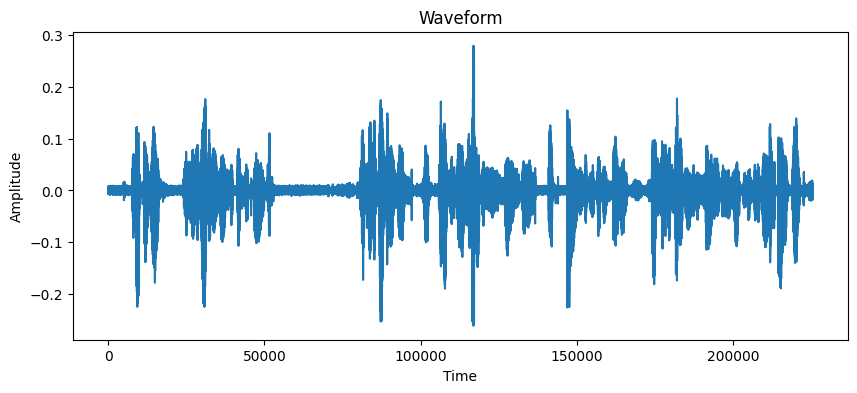

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(waveform[0].numpy())
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [37]:
# Compute the MFCCs using torchaudio
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=40,
    melkwargs={"n_fft":400, "hop_length":160, "n_mels":64}
)

mfcc = mfcc_transform(waveform)

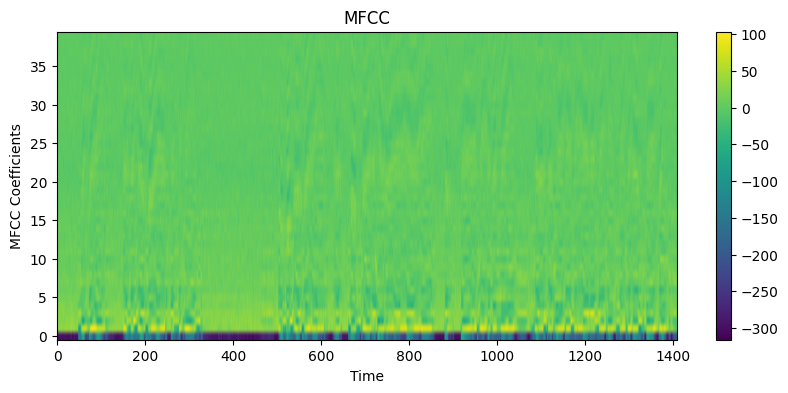

In [38]:
# visualize MFCCs
plt.figure(figsize=(10,4))
plt.imshow(mfcc[0].numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

In [39]:
# Preparing the dataset
from torch.utils.data import DataLoader
import torch.utils.data.dataloader

class SpeechToTextDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.valid_indices = []

        # Check for valid files
        for idx in range(len(dataset)):
            try:
                # Attempt to load the file
                waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[idx]
                self.valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping corrupted file at index {idx}: {e}")

    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        valid_idx = self.valid_indices[idx]
        waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = self.dataset[valid_idx]
        mfcc = mfcc_transform(waveform) # Extracts MFCCs
        # Add normalization
        mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-8)
        
        return mfcc.squeeze(0).transpose(0, 1), transcript # (time, n_mfcc), transcript

In [40]:
# Create a character-to-index mapping
char_to_index = {char: idx for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz '")}
index_to_char = {idx: char for char, idx in char_to_index.items()}

# Add a blank token for CTC (usually the last index)
blank_token = len(char_to_index)
char_to_index["<blank>"] = blank_token
index_to_char[blank_token] = "<blank>"

print("Character to index mapping:", char_to_index)

Character to index mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, "'": 27, '<blank>': 28}


In [41]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Separate MFCCs and transcripts
    mfccs, transcripts = zip(*batch)
    
    # Pad MFCCs to the maximum length in the batch
    mfccs_padded = pad_sequence(mfccs, batch_first=True, padding_value=0.0)
    
    # Convert transcripts to sequences of indices
    targets = []
    for transcript in transcripts:
        # Convert each character to its corresponding index
        target = [char_to_index[char] for char in transcript.lower()]
        targets.append(torch.tensor(target, dtype=torch.long))
    
    # Pad target sequences to the maximum length in the batch
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=blank_token)
    
    # Return padded MFCCs and targets
    return mfccs_padded, targets_padded

In [42]:
# create dataset and dataloader
train_dataset = SpeechToTextDataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

Skipping corrupted file at index 7511: Error : flac decoder lost sync.


In [43]:
# Check a batch
for batch in train_loader:
    mfccs_padded, transcripts = batch
    print(f"MFCCs shape: {mfccs_padded.shape}") # (batch, time, n_mfcc)
    print(f"Transcript: {transcripts}")
    break

MFCCs shape: torch.Size([8, 1476, 40])
Transcript: tensor([[18, 14, 26,  ..., 28, 28, 28],
        [ 0, 13,  3,  ..., 28, 28, 28],
        [ 5, 14, 17,  ..., 28, 28, 28],
        ...,
        [18,  4,  4,  ..., 28, 28, 28],
        [ 0, 13,  3,  ..., 28, 28, 28],
        [14,  7, 26,  ..., 17, 14, 19]])


In [44]:
# Building the model
import torch.nn as nn

class SpeechToTextModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(SpeechToTextModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(2,2)
        )
        self.rnn = nn.LSTM(128, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.log_softmax = nn.LogSoftmax(dim=2)  # Log-softmax for CTC loss

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, n_mfcc, time) -> (batch, time, n_mfcc)
        x = self.cnn(x)
        x = x.transpose(1, 2)  # (batch, time, features) -> (batch, features, time)
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = self.log_softmax(x)  # Apply log-softmax
        return x

In [45]:
# initialize the model
input_dim = 40 # Number of MFCC Features
hidden_dim = 256
output_dim = 29 # 26 letters + space + apostrophe + blank (for CTC)
model = SpeechToTextModel(input_dim, hidden_dim, output_dim)
print(model)

SpeechToTextModel(
  (cnn): Sequential(
    (0): Conv1d(40, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=29, bias=True)
  (log_softmax): LogSoftmax(dim=2)
)


In [46]:
# Defining the CTC loss
ctc_loss = nn.CTCLoss(len(char_to_index) - 1) # Blank is the last index
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
def train(model, dataloader, optimizer, ctc_loss, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_idx, batch in enumerate(dataloader):
            try:
                optimizer.zero_grad()
                # Unpack the batch
                mfccs_padded, targets_padded = batch
                
                # Forward pass
                outputs = model(mfccs_padded)
                
                # Compute input lengths (after CNN downsampling)
                input_lengths = torch.tensor([outputs.size(1)] * outputs.size(0), dtype=torch.long)
                
                # Compute target lengths
                target_lengths = torch.tensor([(t != blank_token).sum().item() for t in targets_padded], dtype=torch.long)

                # Add validation checks
                if torch.any(input_lengths <= 0) or torch.any(target_lengths <= 0):
                    print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(dataloader)}]: Invalid sequence length detected. Skipping batch.")
                    continue
                    
                if torch.any(input_lengths < target_lengths):
                    print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(dataloader)}]: Input length must be greater than target length for CTC. Skipping batch.")
                    continue
                
                # Compute CTC loss
                loss = ctc_loss(
                    outputs.transpose(0, 1),  # (time, batch, num_classes)
                    targets_padded,           # (batch, max_target_len)
                    input_lengths,            # (batch,)
                    target_lengths            # (batch,)
                )
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                
                optimizer.step()
                
                if batch_idx % 10 == 0:
                    print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item()}")
            
            except Exception as e:
                # Handle corrupted files or other errors
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(dataloader)}]: Error encountered - {e}. Skipping batch.")
                continue

In [48]:
# Train the model
train(model, train_loader, optimizer, ctc_loss, epochs=5)

Epoch [1/5], Batch [0/2927], Loss: 4.9206414222717285
Epoch [1/5], Batch [10/2927], Loss: 3.1857798099517822
Epoch [1/5], Batch [20/2927], Loss: 2.954408884048462
Epoch [1/5], Batch [30/2927], Loss: 2.9018630981445312
Epoch [1/5], Batch [40/2927], Loss: 2.881910562515259
Epoch [1/5], Batch [50/2927], Loss: 2.8697826862335205
Epoch [1/5], Batch [60/2927], Loss: 2.8720078468322754
Epoch [1/5], Batch [70/2927], Loss: 2.8672232627868652
Epoch [1/5], Batch [80/2927], Loss: 2.822749376296997
Epoch [1/5], Batch [90/2927], Loss: 2.8449506759643555
Epoch [1/5], Batch [100/2927], Loss: 2.8639843463897705
Epoch [1/5], Batch [110/2927], Loss: 2.837118625640869
Epoch [1/5], Batch [120/2927], Loss: 2.8216967582702637
Epoch [1/5], Batch [130/2927], Loss: 2.8196449279785156
Epoch [1/5], Batch [140/2927], Loss: 2.728438377380371
Epoch [1/5], Batch [150/2927], Loss: 2.6875839233398438
Epoch [1/5], Batch [160/2927], Loss: 2.6194303035736084
Epoch [1/5], Batch [170/2927], Loss: 2.5298385620117188
Epoch [1

In [49]:
# Save the model's state dictionary
torch.save(model.state_dict(), "speech_to_text_model.pth")

In [50]:
# Inference
def predict(model, mfcc):
    model.eval()
    with torch.no_grad():
        outputs = model(mfcc.unsqueeze(0))
        predicted_indices = torch.argmax(outputs, dim=2)
        return predicted_indices

In [52]:
# Load the model's state dictionary
saved_model = SpeechToTextModel(input_dim=40, hidden_dim=256, output_dim=29)
saved_model.load_state_dict(torch.load("speech_to_text_model.pth", weights_only=True))
saved_model.eval()

# Test on a sample
mfcc_sample, transcript_sample = train_dataset[0]
predicted_indices = predict(saved_model, mfcc_sample)

# Convert predicted indices to text 
predicted_text = "".join([index_to_char[idx.item()] for idx in predicted_indices[0]])

print(f"Predicted: {predicted_text} \n& Actual Transcript: {transcript_sample}")

Predicted: <blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank>chhaptteer oonne<blank><blank><blank><blank><blank><blank>   mmis<blank>suus rraccheal  lendd   is ssur<blank>pri<blank>ssedd<blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank>   mmis<blank>ssuss raachhll  la<blank><blank>nnnd<blank>h lliive   jjusstt wherr the  av<blank>innlle<blank><blank>n  maainn   roo<blank>add<blank><blank>   dii<blank>p<blank><blank>  ddowwn in to  a lit<blank>tleehhal<blank>llow<blank><blank><blank><blank>   frriingged   itt al<blank>derrs  nn  laadiee sye ae coopss ann tovveerst  by  aa bbo<blank>ok<blank><blank><blank> 
& Actual Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN 

# Result

At least it not giving everything `<blank>` (like it did at first). I think by improving the model architecture and increasing the number of epochs, this model will work fine 

# Better Speech To Text Model 

How is this better?

Refined the architecture (Added residual connection to CNN, increased the LSTM Layers, Added dropout for regularization)

Introduced Data Augmentation (Added noise injection, Time stretching, Pitch Shifting Simulation)

Training Enhancements (Increased the Epochs to 50, Added learning rate scheduler, implemented model checkpointing, created augemented dataset multiplier)

And also moved the training to GPU



In [ ]:
import torch
import torch.nn as nn
import torchaudio
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loading data from torchaudio datasets
dataset = torchaudio.datasets.LIBRISPEECH(root="data", url="train-clean-100", download=False)

# Get the first sample (unpack all six values)
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[0]

# Print details
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Transcript: {transcript}")
print(f"Speaker ID: {speaker_id}")
print(f"Chapter ID: {chapter_id}")
print(f"Utterance ID: {utterance_id}")

plt.figure(figsize=(10, 4))
plt.plot(waveform[0].numpy())
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Compute the MFCCs using torchaudio
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=40,
    melkwargs={"n_fft":400, "hop_length":160, "n_mels":64}
)

mfcc = mfcc_transform(waveform)

# visualize MFCCs
plt.figure(figsize=(10,4))
plt.imshow(mfcc[0].numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

# Preparing the dataset
class SpeechToTextDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.valid_indices = []

        # Check for valid files
        for idx in range(len(dataset)):
            try:
                # Attempt to load the file
                waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[idx]
                self.valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping corrupted file at index {idx}: {e}")

    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        valid_idx = self.valid_indices[idx]
        waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = self.dataset[valid_idx]
        mfcc = mfcc_transform(waveform) # Extracts MFCCs
        # Add normalization
        mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-8)
        
        return mfcc.squeeze(0).transpose(0, 1), transcript # (time, n_mfcc), transcript

# Create a character-to-index mapping
char_to_index = {char: idx for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz '")}
index_to_char = {idx: char for char, idx in char_to_index.items()}

# Add a blank token for CTC (usually the last index)
blank_token = len(char_to_index)
char_to_index["<blank>"] = blank_token
index_to_char[blank_token] = "<blank>"

print("Character to index mapping:", char_to_index)

def collate_fn(batch):
    # Separate MFCCs and transcripts
    mfccs, transcripts = zip(*batch)
    
    # Pad MFCCs to the maximum length in the batch
    mfccs_padded = pad_sequence(mfccs, batch_first=True, padding_value=0.0)
    
    # Convert transcripts to sequences of indices
    targets = []
    for transcript in transcripts:
        # Convert each character to its corresponding index
        target = [char_to_index[char] for char in transcript.lower()]
        targets.append(torch.tensor(target, dtype=torch.long))
    
    # Pad target sequences to the maximum length in the batch
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=blank_token)
    
    # Return padded MFCCs and targets
    return mfccs_padded.to(device), targets_padded.to(device)

# create dataset and dataloader
train_dataset = SpeechToTextDataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Check a batch
for batch in train_loader:
    mfccs_padded, transcripts = batch
    print(f"MFCCs shape: {mfccs_padded.shape}") # (batch, time, n_mfcc)
    print(f"Transcript: {transcripts}")
    break

# Building the model
class ImprovedSpeechToTextModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Enhanced CNN with more layers and residual connections
        self.cnn = nn.Sequential(
            # First block with residual connection
            nn.Sequential(
                nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Conv1d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU()
            ),
            nn.MaxPool1d(2),
            
            # Second block with residual connection
            nn.Sequential(
                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Conv1d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU()
            ),
            nn.MaxPool1d(2)
        )
        
        # Enhanced LSTM with more layers
        self.rnn = nn.LSTM(
            128, 
            hidden_dim, 
            num_layers=3,  # Increased layers
            batch_first=True, 
            bidirectional=True,
            dropout=0.3
        )
        
        # Projection layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
        
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, n_mfcc, time)
        x = self.cnn(x)
        x = x.transpose(1, 2)  # (batch, time, features)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return self.log_softmax(x)

# initialize the model
input_dim = 40 # Number of MFCC Features
hidden_dim = 256
output_dim = 29 # 26 letters + space + apostrophe + blank (for CTC)
model = ImprovedSpeechToTextModel(input_dim, hidden_dim, output_dim).to(device)
print(model)

# Defining the CTC loss
ctc_loss = nn.CTCLoss(len(char_to_index) - 1) # Blank is the last index
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Data Augmentation
class DataAugmentation:
    @staticmethod
    def add_noise(mfcc, noise_factor=0.005):
        noise = torch.randn_like(mfcc) * noise_factor
        return mfcc + noise

    @staticmethod
    def time_stretch(mfcc, rate=0.8):
        return torch.nn.functional.interpolate(
            mfcc.unsqueeze(0), 
            scale_factor=rate, 
            mode='linear'
        ).squeeze(0)

    @staticmethod
    def pitch_shift(mfcc, shift_range=(-2, 2)):
        shift = np.random.uniform(*shift_range)
        return torch.roll(mfcc, int(shift * mfcc.shape[0]), dims=0)

class AugmentedSpeechDataset(Dataset):
    def __init__(self, original_dataset, augmentations=3):
        self.dataset = original_dataset
        self.augmentations = augmentations

    def __len__(self):
        return len(self.dataset) * (self.augmentations + 1)

    def __getitem__(self, idx):
        base_idx = idx // (self.augmentations + 1)
        aug_type = idx % (self.augmentations + 1)

        mfcc, transcript = self.dataset[base_idx]

        if aug_type == 0:
            return mfcc, transcript
        elif aug_type == 1:
            return DataAugmentation.add_noise(mfcc), transcript
        elif aug_type == 2:
            return DataAugmentation.time_stretch(mfcc), transcript
        else:
            return DataAugmentation.pitch_shift(mfcc), transcript

# Create augmented dataset
augmented_train_dataset = AugmentedSpeechDataset(train_dataset)
augmented_train_loader = DataLoader(
    augmented_train_dataset, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=collate_fn
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3
)

# Enhanced training loop with validation tracking
def train_with_validation(model, train_loader, val_loader, optimizer, ctc_loss, epochs):
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            mfccs_padded, targets_padded = batch
            
            # Forward pass
            outputs = model(mfccs_padded)
            
            # Compute input lengths (after CNN downsampling)
            input_lengths = torch.tensor([outputs.size(1)] * outputs.size(0), dtype=torch.long, device=device)
            
            # Compute target lengths
            target_lengths = torch.tensor([(t != blank_token).sum().item() for t in targets_padded], dtype=torch.long, device=device)

            # Add validation checks
            if torch.any(input_lengths <= 0) or torch.any(target_lengths <= 0):
                print(f"Epoch [{epoch+1}/{epochs}]: Invalid sequence length detected. Skipping batch.")
                continue
                
            if torch.any(input_lengths < target_lengths):
                print(f"Epoch [{epoch+1}/{epochs}]: Input length must be greater than target length for CTC. Skipping batch.")
                continue
            
            # Compute CTC loss
            loss = ctc_loss(
                outputs.transpose(0, 1),  # (time, batch, num_classes)
                targets_padded,           # (batch, max_target_len)
                input_lengths,            # (batch,)
                target_lengths            # (batch,)
            )
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validate model
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                mfccs_padded, targets_padded = batch
                outputs = model(mfccs_padded)
                input_lengths = torch.tensor([outputs.size(1)] * outputs.size(0), dtype=torch.long, device=device)
                target_lengths = torch.tensor([(t != blank_token).sum().item() for t in targets_padded], dtype=torch.long, device=device)
                loss = ctc_loss(
                    outputs.transpose(0, 1),
                    targets_padded,
                    input_lengths,
                    target_lengths
                )
                val_loss += loss.item()
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Model checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

# Train the model
train_with_validation(model, augmented_train_loader, train_loader, optimizer, ctc_loss, epochs=50)

# Save the model's state dictionary
torch.save(model.state_dict(), "speech_to_text_model.pth")

# Inference
def predict(model, mfcc):
    model.eval()
    with torch.no_grad():
        outputs = model(mfcc.unsqueeze(0).to(device))
        predicted_indices = torch.argmax(outputs, dim=2)
        return predicted_indices

# Load the model's state dictionary
saved_model = ImprovedSpeechToTextModel(input_dim=40, hidden_dim=256, output_dim=29).to(device)
saved_model.load_state_dict(torch.load("best_model.pth", map_location=device))
saved_model.eval()

# Test on a sample
mfcc_sample, transcript_sample = train_dataset[0]
predicted_indices = predict(saved_model, mfcc_sample)

# Convert predicted indices to text 
predicted_text = "".join([index_to_char[idx.item()] for idx in predicted_indices[0]])

print(f"Predicted: {predicted_indices} \n& Actual Transcript: {transcript_sample}")